## Spatial Data Mining of Qua-Kit Design Scenarios
By Hangxin Lu
17.07.2017

### Introduction
We have the 3D geometry data describing different design scenarios. We want to find out hidden messages behinds designs. Our task is

* for each proposal, detect the number of communities.
* for all scenarios, categorize them into different types.

First load libraries and example dataset. 


In [1]:
#Libraries
import shapely
import networkx as nx
import json
import community
import pdb
import numpy as np
from scipy.spatial import distance
from community import best_partition
import matplotlib.pyplot as plt
# import ipdb 是一种调试工具
from sklearn import cluster,metrics
from mpl_toolkits.mplot3d import Axes3D
#embed pictures into html
%matplotlib inline 

# Example data set: one design scenario. Each design scenario contains 47 buildings
with open('../data/geometry/1.json') as f:
    data = json.load(f)
total = []

### Feature Extraction
Extract the corrdinates(8 points, 3D) of each buildings. We use the centroid point of building to simplify the task. **Building directions** are neglected for the moment.  

In [48]:
# compute centroid of each building
for i,feature in enumerate(data['features']):
	if (i > 0):
		#for each cube, find the collections of all 8 points
		convexs = set()
		centroid = []

		for surfaces in feature['geometry']['coordinates']:
			surface = surfaces[0][0:4]
			for p in surface:
				convexs.add(tuple(p))
		convexs = list(convexs)
		centroid = [sum([x[0] for x in convexs])/8.0,sum([x[1] for x in convexs])/8.0,sum([x[2] for x in convexs])/8.0]
		total.append(centroid)
# X contains centroids of all the 47 buildings
X = np.matrix(total) #transform into npmatrix for better processing. X shape is (47,3)

In [17]:
# print(convexs)
# print(p)
print(surface)

[[17146792.686298866, 39332163.23823351, 3999.9999999999986], [17148685.950491305, 39335630.315018296, 3999.9999999999986], [17157931.48858415, 39330581.61050511, 3999.9999999999986], [17156038.224391732, 39327114.53372033, 3999.9999999999986]]


In [38]:
# Project shapes onto 2D. Each buildings will be polygons
from shapely.geometry import Polygon
polygon_alles = []
for i,feature in enumerate(data['features']):
    if (i > 0):
		#for each cube, find the collections of all 8 points
        convexs = set()
        centroid = []

        for surfaces in feature['geometry']['coordinates']:
           
            surface = surfaces[0][0:4]
            surface_2d = ((x[0],x[1]) for x in surface)
            for p in surface_2d:
                convexs.add(p)
        convexs_2d = list(convexs)
        polygon = Polygon(convexs_2d)
        polygon_alles.append(polygon)

print(convexs)
print(len(polygon_alles))
print polygon_alles[0].distance(polygon_alles[1])

{(17148963.634543344, 39310322.874480374), (17152811.184670668, 39309427.64894912), (17146874.77497041, 39301345.25751665), (17150722.325097732, 39300450.031985395)}
47


5849.126317189327

In [42]:
adj_poly = np.zeros((47,47))
for c,c_poly in enumerate(polygon_alles):
    for a,a_poly in enumerate(polygon_alles):
        adj_poly[c,a] = c_poly.distance(a_poly)
print(adj_poly)

[[     0.           5849.12631719  26461.99134218 ...,  34522.51384018
   13862.88756126  17958.04066531]
 [  5849.12631719      0.          21534.42877437 ...,  23396.17232335
   19239.29259342  21582.99369975]
 [ 26461.99134218  21534.42877437      0.         ...,  31231.97165908
   14867.5741459   11520.37450165]
 ..., 
 [ 34522.51384018  23396.17232335  31231.97165908 ...,      0.
   43797.06509316  44312.86575878]
 [ 13862.88756126  19239.29259342  14867.5741459  ...,  43797.06509316
       0.           1202.48975152]
 [ 17958.04066531  21582.99369975  11520.37450165 ...,  44312.86575878
    1202.48975152      0.        ]]


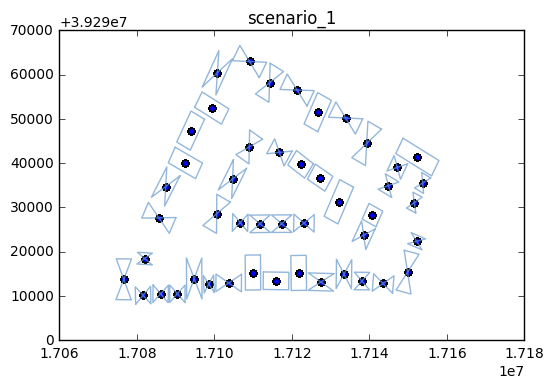

In [50]:
from descartes import PolygonPatch
fig = plt.figure()
ax = fig.add_subplot(111)
for i,poly in enumerate(polygon_alles):
    x,y = poly.exterior.xy
    ax.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=1, solid_capstyle='round', zorder=2)
    ax.scatter(X[:,0],X[:,1],c='b')


ax.set_title('scenario_1')

show the location of the simplied centroid points in 3D and 2D respectively.

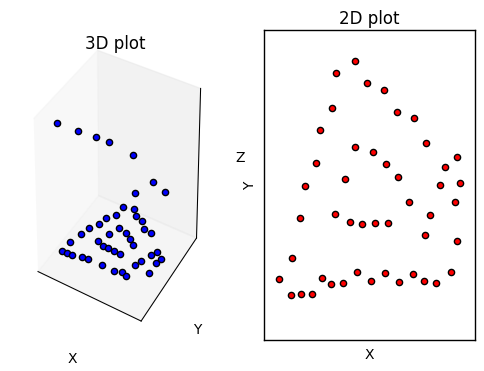

In [3]:
fig = plt.figure()

ax = fig.add_subplot(121, projection='3d')
plt.title('3D plot')
for index in range(X.shape[0]-1):
    xs=X[index,0]
    ys=X[index,1]
    zs=X[index,2]
    ax.scatter(xs,ys,zs,c='b')
    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax2d = fig.add_subplot(122)
plt.title('2D plot')
ax2d.scatter(X[:,0],X[:,1],c='r')
ax2d.set_xlabel('X')
ax2d.set_ylabel('Y')
ax2d.set_xticks([])
ax2d.set_yticks([])

plt.show()

### Community Detection (Clustering)
We want to detect how many buildings groups exists in one scenario. We compute it with respect to 3D and 2D. First plot the histrogram of pairwise distance distribution

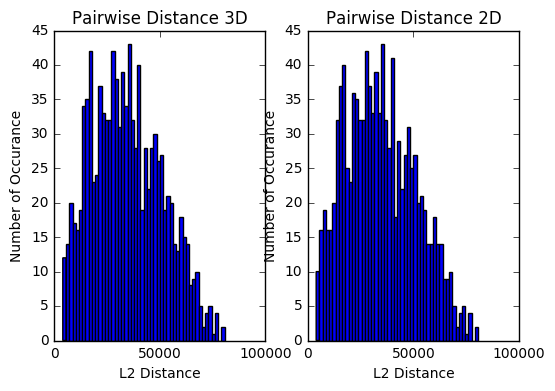

In [4]:
# compute pairwise distance(d2/angle) of 47 * 47 
Y = distance.pdist(X,'euclidean')# pairwise distance 平直的
Z = distance.cdist(X,X,'euclidean')# 47 by 47  

#2D matrix
X_2D = X[:,0:2]
Y_2D = distance.pdist(X_2D,'euclidean')# pairwise distance 平直的
Z_2D = distance.cdist(X_2D,X_2D,'euclidean')# 47 by 47  

#plot
fig = plt.figure()

a=fig.add_subplot(1,2,1)
a.set_title("Pairwise Distance 3D")
plt.xlabel("L2 Distance")
plt.ylabel("Number of Occurance")
plt.hist(Y,bins=50)
# hist, binedge = np.histogram(Y,bins=50)
plt.locator_params(axis = 'x', nbins = 4)

b=fig.add_subplot(1,2,2)
b.set_title("Pairwise Distance 2D")
plt.xlabel("L2 Distance")
plt.ylabel("Number of Occurance")
plt.hist(Y_2D,bins=50)
plt.locator_params(axis = 'x', nbins = 4)

plt.show()
# print(hist)
# print(binedge)

#### DBSCAN(Density Based Method) for 2D

In [51]:
max_distance = np.percentile(Y_2D,7) #The maximum distance between two samples for them to be considered as in the same neighborhood.
dbscan = cluster.DBSCAN(eps=max_distance,min_samples=3)
labels = dbscan.fit_predict(X_2D)
SI_score = metrics.silhouette_score(X_2D,labels)

core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X_2D[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X_2D[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=8)

plt.title('Estimated number of clusters: %d, \n SI score: %s' % (n_clusters_,SI_score))
plt.show()
print(xy)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

#### DBSCAN(Density Based Method) for 3D

In [6]:
max_distance = np.percentile(Y,7) #The maximum distance between two samples for them to be considered as in the same neighborhood.
dbscan = cluster.DBSCAN(eps=max_distance,min_samples=3)
labels = dbscan.fit_predict(X)
SI_score = metrics.silhouette_score(X,labels)

core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

fig = plt.figure()
cols = {}
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'# Black used for noise.
    cols[k]=col


ax = fig.add_subplot(111, projection='3d')
for index in range(X.shape[0]-1):
    xs=X[index,0]
    ys=X[index,1]
    zs=X[index,2]
    color = cols[labels[index]]
    ax.scatter(xs,ys,zs,c=color)
    

plt.title('Estimated number of clusters: %d, \n SI score: %s' % (n_clusters_,SI_score))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [138]:
X.shape

(47, 3)

In [ ]:
clustering_names = ['SpectralClustering','DBSCAN']
n_clusters = 4
spectral = cluster.SpectralClustering(n_clusters = n_clusters,random_state=1)
kmeans = cluster.KMeans(n_clusters = n_clusters, )
labels = kmeans.fit_predict(X)

In [ ]:
X[1]

In [ ]:
# select threshold of distance 
H = np.zeros(Z.shape)
d = np.percentile(Y,10)
# construct adjancy 
for x in range(len(Z)):
	for y in range(len(Z)):
		if ((x!=y) and (Z[x][y] < d)):
			H[x][y] = Z[x][y]

In [ ]:
H

In [ ]:
g =nx.from_numpy_matrix(H)
num_nodes = nx.number_of_nodes(g)
g, deg = calculate_degree(g)

#detect numbers of communities!
part = community.best_partition(g)

In [ ]:
#snapshot of the Network
print (nx.info(g))
deg

In [ ]:
#Create network layout for visuliation 
spring_pos = nx.spring_layout(g)

In [ ]:
plt.axis("off")
nx.draw_networkx(g, pos=spring_pos,with_labels = False, node_size=35)
plt.show()
plt.close()

In [ ]:
#first compute the best partition
partition = community.best_partition(g)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(g)
count = 0.
color = ['k','g','r','c','m','y','b','w']
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(g, pos, list_nodes, node_size = 40,
                                node_color = color[int(count)])


nx.draw_networkx_edges(g,pos, alpha=0.5)
plt.show()
